# Setup dataset

In [11]:
import pandas as pd
import os

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
with open(ANNOTATIONS_PATH+'/annotations.txt','r') as file:
    annotations = file.read().splitlines()[1:]

sampleAnno = 0
def read_data(id: int):
    if '(A)' in annotations[id] or '(B)' in annotations[id]:
        folder, trial, fragId, _, OoM, startSec, endSec = annotations[id].replace(' ','').split(',')[:7]
    else:
        folder, trial, fragId, OoM, startSec, endSec = annotations[id].replace(' ','').split(',')[:6]

    file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
    table = pd.read_csv(file)
    return table
dataTable = read_data(sampleAnno)
dataTable.head()

,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ank_X,left_ank_Y,left_ank_Z,right_ank_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.599149,0.282866,0.281366,0.603479,0.282036,0.196394,0.626746,0.309066,0.291376,0.634263,...,0.310926,0.610581,0.753321,0.244585,0.613030,0.757138,0.178245,0.620697,0.841934,0.245584
1,0.599149,0.282867,0.281366,0.603481,0.282036,0.196393,0.626744,0.309068,0.291374,0.634298,...,0.310933,0.610508,0.753349,0.244600,0.612879,0.757172,0.178267,0.620695,0.841926,0.245566
2,0.599149,0.282866,0.281365,0.603482,0.282037,0.196392,0.626739,0.309063,0.291373,0.634445,...,0.310944,0.610425,0.753376,0.244616,0.612703,0.757201,0.178288,0.620691,0.841918,0.245548
3,0.599152,0.282863,0.281364,0.603482,0.282036,0.196392,0.626735,0.309062,0.291373,0.633893,...,0.310954,0.610346,0.753399,0.244627,0.612542,0.757220,0.178300,0.620685,0.841909,0.245532
4,0.599150,0.282868,0.281363,0.603481,0.282040,0.196393,0.626724,0.309069,0.291376,0.634368,...,0.310969,0.610267,0.753423,0.244642,0.612376,0.757248,0.178315,0.620681,0.841904,0.245516


In [2]:
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
    
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

In [30]:
import numpy as np 

centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(dataTable)],axis=1)
centerOfMassPosTable.columns = ['X','Y','Z']
centerOfMassPosTable = centerOfMassPosTable.apply(lambda row: (row['X'], row['Y'], row['Z']), axis=1)
tableByJoint = group_table_by_joints(dataTable)
jointsDistFromCOM = tableByJoint.sub(centerOfMassPosTable,axis=0)
jointsDistNorm = jointsDistFromCOM.applymap(lambda elem: np.linalg.norm(elem))
jointsDistNormMin, jointsDistNormMax = jointsDistNorm.min(axis=0), jointsDistNorm.max(axis=0)
jointsDistNorm = (jointsDistNorm-jointsDistNormMin)/(jointsDistNormMax-jointsDistNormMin)
jointsDistNormMean = jointsDistNorm.mean(axis=0)
jointsDistNormVar = jointsDistNorm.var(axis=0)
jointsDistNormMAD = jointsDistNorm.median(axis=0).abs()
jointsDistNormSMA = jointsDistNorm.abs().sum(axis=0)/len(jointsDistNorm)
jointsDistNormMSE = jointsDistNorm.apply(lambda row: (row - jointsDistNormMean)**2,axis=1).mean(axis=0)
featureVector = pd.concat([jointsDistNormMean,jointsDistNormVar,jointsDistNormMAD,jointsDistNormSMA,jointsDistNormMSE],axis=0)

dataTable2 = read_data(1)
centerOfMassPosTable = pd.concat([table2.apply(lambda row: row.sum()/20,axis=1) for table2 in table_to_list_xyz_tables(dataTable2)],axis=1)
centerOfMassPosTable.columns = ['X','Y','Z']
centerOfMassPosTable = centerOfMassPosTable.apply(lambda row: (row['X'], row['Y'], row['Z']), axis=1)
tableByJoint = group_table_by_joints(dataTable2)
jointsDistFromCOM = tableByJoint.sub(centerOfMassPosTable,axis=0)
jointsDistNorm = jointsDistFromCOM.applymap(lambda elem: np.linalg.norm(elem))
jointsDistNormMin, jointsDistNormMax = jointsDistNorm.min(axis=0), jointsDistNorm.max(axis=0)
jointsDistNorm = (jointsDistNorm-jointsDistNormMin)/(jointsDistNormMax-jointsDistNormMin)
jointsDistNormMean = jointsDistNorm.mean(axis=0)
jointsDistNormVar = jointsDistNorm.var(axis=0)
jointsDistNormMAD = jointsDistNorm.median(axis=0).abs()
jointsDistNormSMA = jointsDistNorm.abs().sum(axis=0)/len(jointsDistNorm)
jointsDistNormMSE = jointsDistNorm.apply(lambda row: (row - jointsDistNormMean)**2,axis=1).mean(axis=0)

featureVector2 = pd.concat([jointsDistNormMean,jointsDistNormVar,jointsDistNormMAD,jointsDistNormSMA,jointsDistNormMSE],axis=0)
dataframe = pd.concat([featureVector,featureVector2],axis=1).T
dataframe = pd.concat([dataframe,featureVector],axis=0)

dataframe.columns = ['mean_'+col for col in jointsDistNorm.columns]+ \
                        ['var_'+col for col in jointsDistNorm.columns]+ \
                        ['mad_'+col for col in jointsDistNorm.columns]+ \
                        ['sma_'+col for col in jointsDistNorm.columns]+ \
                        ['mse_'+col for col in jointsDistNorm.columns]
dataframe

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

![distribuzioneJoints](../resources/distribuzioneJoints.png)

## Derivatives

In [88]:
import numpy as np
import pandas as pd

def group_table_by_joints(table:pd.DataFrame):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

def compute_derivatives(posTable:pd.DataFrame,timeCol,which:set={'speed'}):
    out = []
    if 'speed' in which:
        velocityTable = pd.DataFrame(np.gradient(posTable,timeCol,axis=0),columns=[f'{c}' for c in posTable.columns])
        out.append(velocityTable)
    if 'acceleration' in which:
        accelerationTable = pd.DataFrame(np.gradient(velocityTable,timeCol,axis=0),columns=[f'{c}' for c in velocityTable.columns])
        out.append(accelerationTable)
    if len(out) == 1:
        return out[0]
    return out

def compute_angular_momentum(posTables,timeCol):
    m_lfoot = 0.0145;m_rfoot = 0.0145;m_lank = 0.0465;m_rank = 0.0465
    m_lknee = 0.1;m_rknee = 0.1;m_lhip = 0.1;m_hipc = 0.139;m_rhip = 0.1
    m_spine = 0.216;m_lhand = 0.006;m_rhand = 0.006;m_lwrist = 0.016;m_rwrist = 0.016
    m_lelb = 0.028;m_relb = 0.028;m_lsho = 0.0158;m_shoc = 0.081;m_rsho = 0.0158;m_head = 0.081

    mass = [m_lfoot, m_rfoot, m_lank, m_rank, m_lknee,  m_rknee, m_lhip, m_hipc, m_rhip, m_spine, m_lhand, m_rhand, m_lwrist, m_rwrist, m_lelb, m_relb, m_lsho, m_shoc, m_rsho, m_head]
    
    posTableX, posTableY, posTableZ = posTables
    posTableX:pd.DataFrame;posTableY:pd.DataFrame;posTableZ:pd.DataFrame

    centerOfMassX = posTableX.dot(mass).div(sum(mass))
    centerOfMassY = posTableY.dot(mass).div(sum(mass))
    centerOfMassZ = posTableZ.dot(mass).div(sum(mass))

    radiusQX = posTableX.sub(centerOfMassX,axis=0)
    radiusQY = posTableY.sub(centerOfMassY,axis=0)
    radiusQZ = posTableZ.sub(centerOfMassZ,axis=0)

    def merge_tables(xTable,yTable,zTable):
        mergedTable = pd.DataFrame()
        for j in range(xTable.shape[1]):
            mergedTable = pd.concat([mergedTable,xTable.iloc[:,j],yTable.iloc[:,j],zTable.iloc[:,j]],axis=1)
        return mergedTable
    
    radiusQTable = merge_tables(radiusQX,radiusQY,radiusQZ)
    p = compute_derivatives(merge_tables(posTableX,posTableY,posTableZ),timeCol).mul(np.repeat(mass,3))

    def split_table(table,into="xyz"):
        if into == "xyz":
            return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
        elif into == "points":
            return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]
        
    p = [point.to_numpy() for point in split_table(p,into="points")]
    r = [point.to_numpy() for point in split_table(radiusQTable, into="points")]
    l = np.cross(p,r)

    angularMomentumTable = radiusQTable*0
    for j,point in enumerate(l):
        for i in range(len(point)):
            angularMomentumTable.iloc[i,3*j:3*j+3] = point[i]
    return angularMomentumTable

## Similarity functions 

In [89]:
from scipy.spatial.distance import cosine
def compute_cosine_similarity_on_joints(featureTable,normalized:None or int=None):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 8, 8,10,11,13,15,17,12,14,16,18,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 9,10,18,13,15,17,18,14,16,19,19,20]

    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    cosineSim = pd.DataFrame()
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        cosineSim[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: 2 - cosine(row[columnNames[jointFrom]],row[columnNames[jointTo]]),axis=1)
    return cosineSim if normalized is None else cosineSim.div(cosineSim.max(axis=1))*normalized

from numpy.linalg import norm
def compute_inverse_difference_on_joints(featureTable):
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))

    invDiffModulus = pd.DataFrame()
    eps = 10**(-9)  # To avoid division by 0
    columnNames = list(featureTable.columns)
    for jointFrom,jointTo in zip(jointsFrom,jointsTo):
        invDiffModulus[columnNames[jointFrom]+" - "+columnNames[jointTo]] = featureTable.apply(lambda row: norm(row[columnNames[jointFrom]]-row[columnNames[jointTo]])+eps,axis=1)
    return 1 / invDiffModulus
    

def group_table_by_joints(table):
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

## Optional functions for rotating, filtering, plotting

In [90]:
def filter_and_rotate_table(picked:int,posTable:pd.DataFrame):
    if 1 <= picked <= 10:
        posTableY = posTable.iloc[:,::3]
        posTableZ = posTable.iloc[:,1::3]
        posTableX = posTable.iloc[:,2::3]
    elif 11 <= picked <= 16:
        posTableX = posTable.iloc[:,::3]
        posTableZ = posTable.iloc[:,1::3]
        posTableY = posTable.iloc[:,2::3]
    elif (17 <= picked <= 20 and picked != 19) or picked >= 25:
        posTableY = posTable.iloc[:,::3]
        posTableX = posTable.iloc[:,1::3]
        posTableZ = posTable.iloc[:,2::3]
    else:
        posTableX = posTable.iloc[:,::3]
        posTableY = posTable.iloc[:,1::3]
        posTableZ = posTable.iloc[:,2::3]

    posTableX = posTableX.rename(columns=dict(zip(list(posTableX),[name.replace('Z','X').replace('Y','X') for name in list(posTableX)])))
    posTableY = posTableY.rename(columns=dict(zip(list(posTableY),[name.replace('Z','Y').replace('X','Y') for name in list(posTableY)])))
    posTableZ = posTableZ.rename(columns=dict(zip(list(posTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(posTableZ)])))

    return (posTableX,posTableY,posTableZ)


from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

def draw_skeleton(posTable:tuple,picked:int):
    posTableX,posTableY,posTableZ = posTable
    posTableX:pd.DataFrame
    posTableY:pd.DataFrame
    posTableZ:pd.DataFrame
    plt.close("all")
    %matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    minMax = np.zeros((2,3))
    minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
    minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

    print(minMax)

    # Set appropriate axis limits
    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])

    # Set the window title
    fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

    # Set the initial time index
    time_index = 0

    # Function to update the plot based on the slider value
    def update_plot(val):
        ax.cla()  # Clear the previous plot

        # Filter the data based on the current time index
        filteredX = posTableX.iloc[val]
        filteredY = posTableY.iloc[val]
        filteredZ = posTableZ.iloc[val]

        ax.scatter(filteredX,filteredY,filteredZ)

        ax.set_xlim([minMax[0,0],minMax[1,0]])
        ax.set_ylim([minMax[0,1],minMax[1,1]])
        ax.set_zlim([minMax[0,2],minMax[1,2]])

        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_zlabel('Z', fontsize=12)
        ax.set_title("Movement "+str(picked))

        fig.canvas.draw_idle()

    # Create a slider widget
    slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
    maxValue = posTable.shape[0]-1
    slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


    # Define a function to update the slider value with the mouse wheel
    def on_scroll(event):
        if event.button == 'down':
            if slider.val + slider.valstep*5 <= maxValue:
                slider.set_val(slider.val + slider.valstep*2)
        elif event.button == 'up':
            if slider.val - slider.valstep*10 >= 0:
                slider.set_val(slider.val - slider.valstep*2)


    # Connect the mouse wheel event to the function
    fig.canvas.mpl_connect('scroll_event', on_scroll)


    # Register the update_plot function with the slider widget
    slider.on_changed(update_plot)

    # Initial plot
    update_plot(time_index)

    # Show the plot
    plt.show()

# Filling up the dataset

Infos about the dataset
```
Video Names Mapping and manual annotation:

Muriel t_003.1 ==> 1 ==> Shoc/Rsho
Muriel t_003.2 ==> 2 ==> Hipc/Head !!
Muriel t_003.3 ==> 3 ==> Rhip/Hipc
Muriel t_004 ==> 4 ==> Shoc/Lsho

Marianne t_002.1 ==> 5 ==> Shoc/Head
Marianne t_002.2 ==> 6 ==> Rknee/Rank
Marianne t_003 ==> 7 ==> Lsho/Shoc
Marianne t_005.1 ==> 8 ==> Rsho/Shoc
Marianne t_005.2 ==> 9 ==> Rank/Hipc !!
Marianne t_012 ==> 10 ==> Shoc/Lsho !!

Cora t_028.1 ==> 11 ==> Rwrist/Rhand
Cora t_028.2 ==> 12 ==> Relb/Head
Cora t_028.3 ==> 13 ==> Lank/Lhip
Cora t_028.4 ==> 14 ==> Lknee/Lhip
Cora t_028.5 ==> 15 ==> Lwrist/Lsho
Cora t_028.6 ==> 16 ==> Hipc/Shoc !!

No OoM.1 (07-07 t_052) ==> 19 ==> No
No OoM.2 (07-07 t_052) ==> 18 ==> No

07-07 t_051 ==> 17 ==> Rknee/Lknee !!
07-07 t_052 ==> 20 ==> Shoc/Hipc !!
07-07 t_060 ==> 21 ==> Rsho/Relb
07-07 t_061 ==> 22 ==> Lelb/Shoc
07-07 t_063 ==> 23 ==> Lelb/Shoc
07-07 t_064 ==> 24 ==> Relb/Rwrist

07-08 t_052_A.1 ==> 25 ==> Lknee/Rknee !!
07-08 t_052_B.1 ==> 26 ==> Lknee/Shoc
07-08 t_052_A.2 ==> 27 ==> Shoc/Lelb
07-08 t_052_B.2 ==> 28 ==> Rknee/Lknee !!
07-08 t_053_A.1 ==> 29 ==> Lknee/Rknee
07-08 t_053_B.1 ==> 30 ==> Rknee/Shoc
07-08 t_053_A.2 ==> 31 ==> Rhip/Shoc
07-08 t_053_B.2 ==> 32 ==> Rknee/Relb

07-13 t_061_A.1 ==> 33 ==> Lelb/Relb
07-13 t_061_B.1 ==> 34 ==> Lknee/Rknee
07-13 t_061_A.2 ==> 35 ==> Rknee/Shoc
07-13 t_061_B.2 ==> 36 ==> Rsho/Relb
```

In [160]:
edgeNames = ['Lfoot-Lankle',           
          'Rfoot-Rankle',           
          'Lankle-Lknee',           
          'Rankle-Rknee',           
          'Lknee-Lhip',
          'Rknee-Rhip',
          'Lhip-Chip',
          'Rhip-Chip',
          'Chip-spine',
          'spine-Cshoulder',
          'Lhand-Lwrist',
          'Rhand-Rwrist',
          'Lwrist-Lelbow',
          'Rwrist-Relbow',
          'Lelbow-Lshoulder',
          'Relbow-Rshoulder',       
          'Lshoulder-Cshoulder',    
          'Rshoulder-Cshoulder',    
          'Cshoulder-head']         
jointNames = [  'left_foot',
                'right_foot',
                'left_ankle',
                'right_ankle',
                'left_knee',
                'right_knee',
                'left_hip',
                'hip_center',
                'right_hip', 
                'spine',
                'left_hand',
                'right_hand',
                'left_wrist',
                'right_wrist',
                'left_elbow',
                'right_elbow',
                'left_shoulder',
                'shoulder_center',
                'right_shoulder',
                'head'  ]
y_mask =     {1:    [edgeNames.index('Rshoulder-Cshoulder')],
              2:    [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Cshoulder-head')],
              3:    [edgeNames.index('Rhip-Chip')],
              4:    [edgeNames.index('Lshoulder-Cshoulder')],
              5:    [edgeNames.index('Cshoulder-head')],
              6:    [edgeNames.index('Rankle-Rknee')],
              7:    [edgeNames.index('Lshoulder-Cshoulder')],
              8:    [edgeNames.index('Rshoulder-Cshoulder')],
              9:    [edgeNames.index('Rankle-Rknee'),edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip')],
              10:   [edgeNames.index('Lshoulder-Cshoulder')],
              11:   [edgeNames.index('Rhand-Rwrist')],
              12:   [edgeNames.index('Relbow-Rshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Cshoulder-head')],
              13:   [edgeNames.index('Lankle-Lknee'),edgeNames.index('Lknee-Lhip')],
              14:   [edgeNames.index('Lknee-Lhip')],
              15:   [edgeNames.index('Lwrist-Lelbow'),edgeNames.index('Lelbow-Lshoulder')],
              16:   [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              17:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Lknee-Lhip')],
              18:   [],
              19:   [],
              20:   [edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              21:   [edgeNames.index('Relbow-Rshoulder')],
              22:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder')],
              23:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder')],
              24:   [edgeNames.index('Rwrist-Relbow')],
              25:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              26:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              27:   [edgeNames.index('Lshoulder-Cshoulder'),edgeNames.index('Lelbow-Lshoulder')],
              28:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              29:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              30:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              31:   [edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder')],
              32:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Relbow-Rshoulder')],
              33:   [edgeNames.index('Lelbow-Lshoulder'),edgeNames.index('Lshoulder-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder'),edgeNames.index('Relbow-Rshoulder')],
              34:   [edgeNames.index('Lknee-Lhip'),edgeNames.index('Lhip-Chip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Rknee-Rhip')],
              35:   [edgeNames.index('Rknee-Rhip'),edgeNames.index('Rhip-Chip'),edgeNames.index('Chip-spine'),edgeNames.index('spine-Cshoulder'),edgeNames.index('Rshoulder-Cshoulder')],
              36:   [edgeNames.index('Relbow-Rshoulder')]
              }
for edgeIndex in y_mask[35]:
    print(edgeNames[edgeIndex])

y_trans=[]
for key, value in y_mask.items():
    y_trans.append(value)

from sklearn.preprocessing import MultiLabelBinarizer 
mlb = MultiLabelBinarizer()

y_converted = mlb.fit_transform(y_trans)

mlb.classes_   

print(y_converted.shape)

Rknee-Rhip
Rhip-Chip
Chip-spine
spine-Cshoulder
Rshoulder-Cshoulder
(36, 16)


In [147]:
import pandas as pd
from numpy.linalg import norm
from sklearn.preprocessing import MultiLabelBinarizer


columns = [elem for tup in [('X_'+pair[0]+'_avg','X_'+pair[1]+'_var') for pair in zip(jointNames,jointNames)] for elem in tup] + ['Y_OneHot_'+edgeName for edgeName in edgeNames]
column_types = [float if j < len(columns)-len(edgeNames) else bool for j,k in enumerate(columns)]
dataset = pd.DataFrame(index=np.arange(len(DRIVE_POS_MAP.keys())), columns=columns).astype(dict(zip(columns,column_types)))

# Helper function to calculate mean and variance of every joint
calc_mean_and_var = lambda j: (
    speedTable.iloc[:, j : j + 3].apply(lambda row: norm(row), axis=1).mean(),
    speedTable.iloc[:, j : j + 3].apply(lambda row: norm(row), axis=1).var(),
)
oneHotEncoding = np.zeros(len(edgeNames),dtype=bool)

mlb = MultiLabelBinarizer()
for items in y_mask:
    y_converted = mlb.fit_transform(items)
    print(y_converted)

for i,indx_in_drive in enumerate(DRIVE_POS_MAP.keys()):
    data = DRIVE_POS_MAP[indx_in_drive]
    table = pd.read_table(data[0])
    startEndSeconds = data[1]
    timeCol = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])]["Time"]
    table = table[table["Time"].between(startEndSeconds[0],startEndSeconds[1])].iloc[:,1:]
    speedTable = compute_derivatives(table,timeCol) 
    accelerationTable = compute_derivatives(speedTable, timeCol)

    # Assign the calculated values to the dataset
    for j in range(0,len(speedTable.columns),3):
        dataset.loc[i, f'X_{jointNames[j//3]}_avg'], dataset.loc[i, f'X_{jointNames[j//3]}_var'] = calc_mean_and_var(j)

    # Assign the calculated values to the dataset
    #for j in range(0,len(accelerationTable.columns),3):
    #    dataset.loc[i, f'X_{jointNames[j//3]}_avg'], dataset.loc[i, f'X_{jointNames[j//3]}_var'] = calc_mean_and_var(j)

    

    oneHotEncoding[y_mask[indx_in_drive]] = 1
    dataset.iloc[i,-len(edgeNames):] = oneHotEncoding
    oneHotEncoding[y_mask[indx_in_drive]] = 0



dataset

TypeError: 'int' object is not iterable

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [163]:
X = dataset.iloc[:,:40]
y = dataset.iloc[:,40:]
df = pd.DataFrame(X)
X = df.values
df = pd.DataFrame(y)
y = df.values

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)


(36, 40)


## KNeighbors Classifier

In [95]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss

# Generate synthetic multi-label dataset
#X, y = make_multilabel_classification(n_samples=100, n_features=10, n_classes=5, random_state=42)

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss)

Accuracy: 0.0
Hamming Loss: 0.18421052631578946


## Neural Network

In [96]:
class NeuralNetwork:
    def __init__(self, n_features, n_neurons, n_output):
        np.random.seed(1)
        self.w1 = np.random.randn(n_features, n_neurons)

        np.random.seed(2)
        self.w2 = np.random.randn(n_neurons, n_output)

        #learning rate
        self.lr = 0.01


    def calc_loss(self, y_hat, y):
        return ((y-y_hat)**2).mean()


    def plot_loss(self, loss):
        plt.plot(loss.keys(), loss.values())
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid
        plt.show()

    def sigmoid (self, x):
        return 1.0 / (1.0 + np.exp(-x))


    def d_sigmoid(self, x):
        return x * (1 - x)


    def feedforward(self, X):
        self.layer1 = self.sigmoid(X @ self.w1)
        self.output = self.sigmoid(self.layer1 @ self.w2)


    def backpropagation(self, X, y):
        d2 = self.output - y
        d1 = (self.w2 @ d2.T).T * self.d_sigmoid(self.layer1)

        w1_d = X.T @ d1
        w2_d = self.layer1.T @ d2

        self.w1 -= self.lr * w1_d
        self.w2 -= self.lr * w2_d

    def fit(self, X, y, epochs=1, lr=0.01):
        self.lr = lr

        loss_dict = {}

        for i in range(epochs):
            np.random.seed(1)
            self.feedforward(X)
            self.backpropagation(X_train, y_train)

            loss = self.calc_loss(self.output, y_train)
            loss_dict[i] = loss   

            if (i+1) % 100 == 0:
                train_preds = self.predict(X_train).round()
                test_preds = self.predict(X_test).round()

                train_acc = round(accuracy_score(train_preds, y_train), 4)
                test_acc = round(accuracy_score(test_preds, y_test), 4)

                print(f'Epoch: {i+1} | Loss: {round(loss, 3)} | Train Acc: {train_acc} | Test Acc: {test_acc}')

        self.plot_loss(loss_dict)


    def predict(self, X):
        self.feedforward(X)
        return self.output      

Epoch: 100 | Loss: 0.116 | Train Acc: 0.0714 | Test Acc: 0.0
Epoch: 200 | Loss: 0.096 | Train Acc: 0.0714 | Test Acc: 0.0
Epoch: 300 | Loss: 0.09 | Train Acc: 0.0714 | Test Acc: 0.0


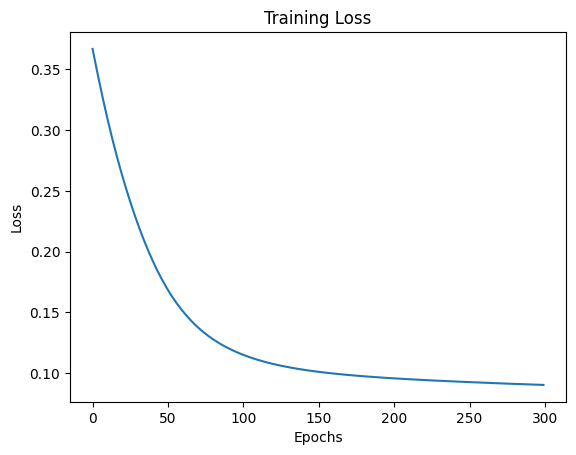

In [97]:
nn = NeuralNetwork(40, 10, 19)  # Adjusting n_features and n_output

nn.fit(X_train, y_train, epochs=300, lr=0.001)

## Decision Tree

In [103]:
#TRAN QUANG DAT - 14520156
#created in December 15 2017
#MultiLabel-DecicisionTree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris
import random
import math

#Load Iris Data from sklearn
iris = load_iris()
#Use Pandas method to import data into pandas DataFrame, save them in balanced_data
balance_data = pd.DataFrame(iris.data, columns=iris.feature_names)
balance_data=dataset
#Check the length and dimension of DataFrame
lengthData = len(balance_data)
print ("Dataset Shape: ",balance_data.shape )
print ("Dataset:")
print (balance_data)
#Split data into train and test
X = balance_data.values[:, 1:4]
Y = balance_data.values[:,0]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
print(X_train)
#Devide dataset into train and test with 7:3
numof_data_train = math.ceil(lengthData*0.7)
numof_data_test = math.floor(lengthData*0.3)
#Determine data_train by 1 and data_test by 0
data_train = [1 for i in range(0,numof_data_train)]
data_train.extend([0 for i in range(0,numof_data_test)])
#Use random Shuffe to mix data
random.shuffle(data_train)
#Creat a column to represent for Category of Data and a column to represent for Data in Train or Test
balance_data['Category'] = pd.Categorical.from_codes(iris.target,iris.target_names)
balance_data['Infor'] = data_train
#Train data
train, test = balance_data[balance_data['Infor']==1], balance_data[balance_data['Infor']==0]
real_labels = pd.factorize(test['Category'])[0]
y = pd.factorize(train['Category'])[0]
x = train[balance_data.columns[:4]]
#Apply Decision Tree of Sklearn
clf = DecisionTreeClassifier(random_state=100)
clf = clf.fit(x,y)
#Test
predicted_labels = clf.predict(test[balance_data.columns[:4]])
#Compare real and test
print("Real labels: ")
print(real_labels)
print("Predicted labels: ")
print(predicted_labels)
#Apply Accuracy_score for checking accuracy
print ("Accuracy is", accuracy_score(real_labels,predicted_labels)*100)

Dataset Shape:  (36, 59)
Dataset:
    X_left_foot_avg  X_left_foot_var  X_right_foot_avg  X_right_foot_var  \
0          0.007774     7.058829e-05          0.016240      2.744935e-04   
1          0.011890     1.629459e-04          0.020960      6.396525e-04   
2          0.196221     9.350937e-02          1.767068      3.546706e+00   
3          0.153154     3.788091e-02          0.572844      6.323509e-01   
4          0.003769     2.251460e-05          0.005164      3.626099e-05   
5          0.007820     6.452291e-05          0.389714      1.181945e-01   
6          0.000617     2.500998e-07          0.000552      1.632158e-07   
7          0.001831     2.373220e-06          0.003056      1.134762e-05   
8          0.007563     4.565466e-05          0.295923      5.387698e-01   
9          0.029616     8.773440e-04          0.016128      3.522086e-04   
10         0.010689     9.610476e-04          0.003018      1.625743e-05   
11         0.096384     3.785791e-02          0.061323

ValueError: Length of values (150) does not match length of index (36)

## Random Forest

In [142]:
#TRAN QUANG DAT - 14520156
#created in December 15 2017
#MultiLabel-DecicisionTree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris

#find Average Accuracy
total = 0
for i in range(0,10):
    #Apply Random Forest of Sklearn
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    clf = clf.fit(X_train,y_train)
    #Test
    predicted_labels = clf.predict(X_test)
    #Compare real and test
    #Apply Accuracy_score for checking accuracy

    temp = accuracy_score(y_test,predicted_labels)*100
    total = total + temp
    print ("Accuracy is", temp)   
    print ("Average Accuracy of 10 tests:", total/10)

Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
Accuracy is 0.0
Average Accuracy of 10 tests: 0.0
